In [49]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '..')


# Import our functions
from moment_conversion import *
from ssid import *
from simulate import *

# Import other things that might be useful
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.linalg import subspace_angles
import scipy.io as sio

# Formatting
colors = np.array([[95,59,151],[85,180,103],[250,186,63],[150,150,150],[0,0,0]])/255

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

# set plot design features
font = {'family'   : 'sans-serif',
        'sans-serif' : 'Helvetica',
        'weight'   : 'regular',
        'size'     : 24}

mpl.rc('font', **font)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Load data

In [2]:
y = np.load('../data/real-data/d2mice_outputs.npy')
y = 1-np.nonzero(y)[1][np.newaxis].T
inputs = np.load('../data/real-data/d2mice_inputs.npy')

#### Obtain SVD of Hankel Matrix

In [3]:
q = y.shape[1] # number of observation dimensions
k = 30 # pick sufficiently large hankel size
p = 30 # pick sufficiently large state dimension
singvals = np.zeros((5,k))

for i in range(1,6):
    u = np.hstack((inputs[:,0:i],inputs[:,-2:])) # loop over different possible number of inputs
    m = u.shape[1] # number of input dimensions

    # moment conversion
    y_reshaped = future_past_Hankel_order_stream(y, k, q).T
    u_reshaped = future_past_Hankel_order_stream(u, k, m).T
    mu_zs, mu_us, sigma_zz, sigma_uu, sigma_zu = fit_mu_sigma_bernoulli_driven(y_reshaped, u_reshaped)

    # rearrange sigma, get estimate of covariance w 
    sigma_zz_full = tril_to_full(sigma_zz, 2 * k * q)
    sigma_what = get_sigmaw_driven(sigma_uu, sigma_zz_full, sigma_zu)

    # cholesky decompose R
    R = get_R(sigma_what)

    # run n4sid
    Ahat,Bhat,Chat,Dhat,_,_,_,ss = driven_n4sid(R,k,m,p,q)
    
    # save SVD
    singvals[i-1] = ss

/jukebox/pkgs/ANACONDAPY/5.1.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


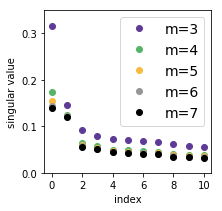

In [4]:
plt.figure(figsize=(3,3))
for i in range(singvals.shape[0]):
    plt.plot(singvals[i,:], '.', label="m=%s" %(i+3),markersize=12, color=colors[i])
plt.xlim([-0.5, 10.5])
plt.xticks(np.arange(0,10.1,2))
plt.ylim([0.0,0.35])
plt.yticks(np.arange(0,0.31,0.1))
plt.xlabel('index')
plt.ylabel('singular value')
plt.legend(fontsize=14)
#plt.savefig('saved_images/fig4b.pdf', transparent=True)

#### Compute prediction accuracy over range of p and m

In [105]:
q = y.shape[1] # number of observation dimensions
k = 30 # pick sufficiently large hankel size
frac_correct = np.zeros((4,5))

ps = [2,3,4,5]

for pdx,p in enumerate(ps):
    for i in range(1,6):
        u = np.hstack((inputs[:,0:i],inputs[:,-2:]))
        m = i+2

        # moment conversion
        y_reshaped = future_past_Hankel_order_stream(y, k, q).T
        u_reshaped = future_past_Hankel_order_stream(u, k, m).T
        mu_zs, mu_us, sigma_zz, sigma_uu, sigma_zu = fit_mu_sigma_bernoulli_driven(y_reshaped, u_reshaped)

        # rearrange sigma, get estimate of covariance w 
        sigma_zz_full = tril_to_full(sigma_zz, 2 * k * q)
        sigma_what = get_sigmaw_driven(sigma_uu, sigma_zz_full, sigma_zu)

        # cholesky decompose R
        R = get_R(sigma_what)

        # run n4sid
        Ahat,Bhat,Chat,Dhat,Qhat,Rhat,Shat,ss = driven_n4sid(R,k,m,p,q)

        x0 = np.zeros(q)
        d = np.zeros(q)
        muu = np.zeros(2) # don't actually matter but are required inputs for this function
        Qu = np.eye(2) # don't actually matter but are required inputs for this function
        
        y_sim, _, _, z_sim, _ = simulate_driven_noiseless_bernoulli_lds(len(y),x0,Ahat,Bhat,Chat,
                                                                        Dhat,d,muu,Qu,inputs=u)

        # compute fraction correct
        frac_correct[pdx,i-1] = np.sum([y_sim==y])/len(y)
        print('p = %s, m = %s, fraction correct = %.3f' %(p, m, frac_correct[pdx,i-1]))

p = 2, m = 3, fraction correct = 0.697
p = 2, m = 4, fraction correct = 0.701
p = 2, m = 5, fraction correct = 0.701
p = 2, m = 6, fraction correct = 0.700
p = 2, m = 7, fraction correct = 0.700
p = 3, m = 3, fraction correct = 0.697
p = 3, m = 4, fraction correct = 0.702
p = 3, m = 5, fraction correct = 0.702
p = 3, m = 6, fraction correct = 0.701
p = 3, m = 7, fraction correct = 0.701
p = 4, m = 3, fraction correct = 0.697
p = 4, m = 4, fraction correct = 0.702
p = 4, m = 5, fraction correct = 0.701
p = 4, m = 6, fraction correct = 0.701
p = 4, m = 7, fraction correct = 0.701
p = 5, m = 3, fraction correct = 0.698
p = 5, m = 4, fraction correct = 0.702
p = 5, m = 5, fraction correct = 0.702
p = 5, m = 6, fraction correct = 0.626
p = 5, m = 7, fraction correct = 0.702


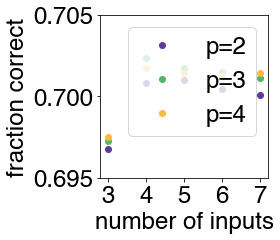

In [184]:
plt.figure(figsize=(3,3))
for i in range(3):
    plt.plot(frac_correct[i,:],'.',label="p=%s" %(i+2),markersize=12,color=colors[i])
#plt.xlim([-0.5, 10.5])
plt.xticks(ticks=np.arange(5),labels=np.arange(3,8,1))
plt.ylim([0.695,0.705])
plt.xlabel('number of inputs')
plt.ylabel('fraction correct')
plt.legend()
#plt.savefig('saved_images/fig4c.pdf', transparent=True)

#### compare best-LDS with optimal p and m to select baselines

In [36]:
### BASELINE 1: PERSEVERATIVE MODEL ###
num_sims = 100
percent_match = np.zeros(num_sims)
## set probabilities
prob_stay = 0.7 # probability of repeating previous choice
probs = [prob_stay,1-prob_stay]

for sim in range(num_sims):
    ## simulate choices
    yt = y[0][0] # observation at t=1
    y_perseverative = np.zeros_like(y)
    y_perseverative[0] = yt
    for i in range(1,len(y)):
        y_perseverative[i] = np.random.choice([yt,1-yt],p=probs)
        yt = y_perseverative[i][0]
    ## compare to real data
    num_matches = len(y) - np.sum(abs(y - y_perseverative))
    percent_match[sim] = num_matches / len(y)
    
average_percent_match = np.mean(percent_match)

Text(0,0.5,'fraction correct')

/jukebox/pkgs/ANACONDAPY/5.1.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


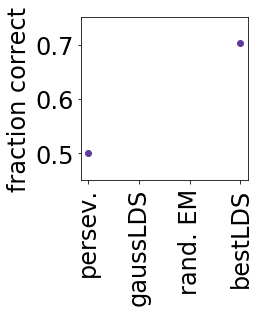

In [64]:
plt.figure(figsize=(3,3))
performance = [average_percent_match, np.nan, np.nan, 0.702]
plt.plot(performance,'.',markersize=12,color=colors[0])
plt.xticks(np.arange(4),['persev.', 'gaussLDS', 'rand. EM', 'bestLDS'],rotation=90)
plt.ylim([0.45,0.75])
plt.ylabel('fraction correct')

#### best-LDS recovered system parameters for chosen combination of p and m

In [65]:
q = y.shape[1] # number of observation dimensions
k = 30 # pick sufficiently large hankel size
p = 3
m = 4
u = np.hstack((inputs[:,0:2],inputs[:,-2:]))

# moment conversion
y_reshaped = future_past_Hankel_order_stream(y, k, q).T
u_reshaped = future_past_Hankel_order_stream(u, k, m).T
mu_zs, mu_us, sigma_zz, sigma_uu, sigma_zu = fit_mu_sigma_bernoulli_driven(y_reshaped, u_reshaped)

# rearrange sigma, get estimate of covariance w 
sigma_zz_full = tril_to_full(sigma_zz, 2 * k * q)
sigma_what = get_sigmaw_driven(sigma_uu, sigma_zz_full, sigma_zu)

# cholesky decompose R
R = get_R(sigma_what)

# run n4sid
Ahat,Bhat,Chat,Dhat,Qhat,Rhat,Shat,ss = driven_n4sid(R,k,m,p,q)

#### True vs. Simulated observations for chosen combination of p and m

In [68]:
x0 = np.zeros(q)
d = np.zeros(q)
muu = np.zeros(2) # don't actually matter but are required inputs for this function
Qu = np.eye(2) # don't actually matter but are required inputs for this function
y_sim, x_sim, _, z_sim, _ = simulate_driven_noiseless_bernoulli_lds(len(y),x0,Ahat,Bhat,Chat,Dhat,d,muu,Qu,inputs=u)

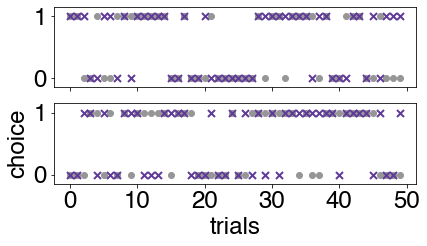

In [237]:
fig, axs = plt.subplots(2,1,sharex=True)
fig.set_size_inches(6.5, 3.25)

ix1 = [11510,11560]
ntrials = 50

for i in range(2):
    axs[i].plot(y[ix1[i]:ix1[i]+ntrials],'.',markersize=12,color=colors[3])
    axs[i].plot(y_sim[ix1[i]:ix1[i]+ntrials],'x',markersize=7,markeredgewidth=2,color=colors[0])
    axs[i].set_ylim([-0.15,1.15])
    axs[i].set_xticks(np.arange(0,51,10))

plt.xlabel('trials')
plt.ylabel('choice')
#plt.savefig('saved_images/fig4d.pdf', transparent=True)

#### show recovered latents

/jukebox/pkgs/ANACONDAPY/5.1.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


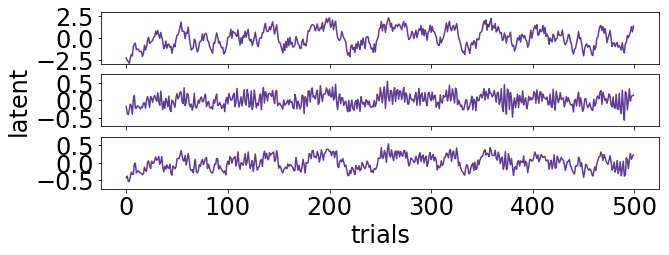

In [93]:
fig, axs = plt.subplots(3,1,sharex=True)
fig.set_size_inches(10, 3.25)

ix1 = 11510
ntrials = 500
yaxis_limits = np.array([[-3,3],[-0.75,0.75],[-0.75,0.75]])
for i in range(3):
    axs[i].plot(x_sim[ix1:ix1+ntrials,i],'-',color=colors[0])
    if i==1:
        axs[i].set_ylabel('latent')
    axs[i].set_ylim(yaxis_limits[i])

plt.xlabel('trials')
plt.savefig('saved_images/fig4_recovered_latents.pdf', transparent=True)

#### show recovered parameters

/jukebox/pkgs/ANACONDAPY/5.1.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


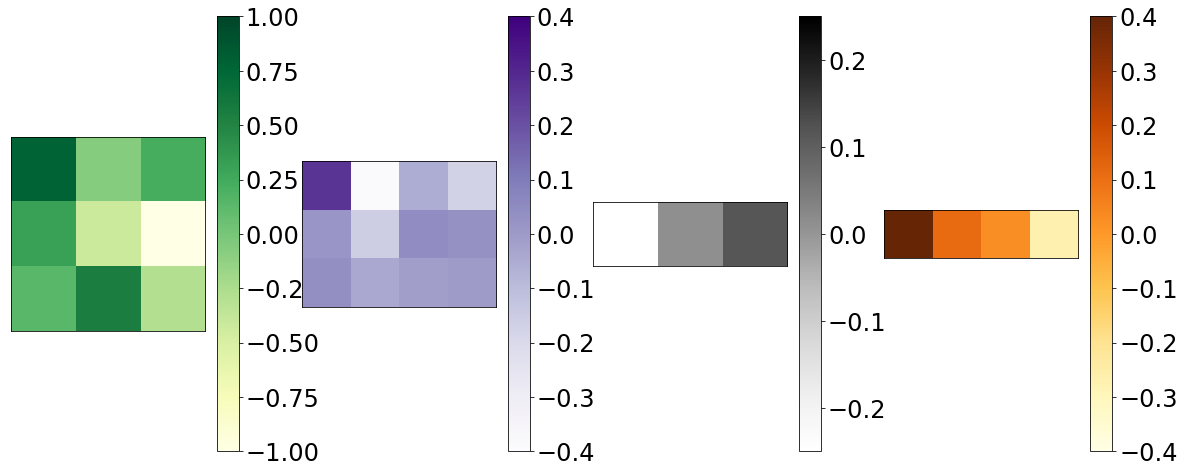

In [90]:
plt.figure(figsize=(20, 8))
plt.subplot(1,4,1)
plt.imshow(Ahat, vmin=-1, vmax=1, cmap='YlGn')
plt.colorbar()
plt.tick_params(axis='both',which='both',bottom=False,labelbottom=False,left=False,labelleft=False)

plt.subplot(1,4,2)
plt.imshow(Bhat, vmin=-0.4, vmax=0.4, cmap='Purples')
plt.colorbar()
plt.tick_params(axis='both',which='both',bottom=False,labelbottom=False,left=False,labelleft=False)

plt.subplot(1,4,3)
plt.imshow(Chat,  vmin=-0.25, vmax=0.25, cmap='Greys')
plt.colorbar()
plt.tick_params(axis='both',which='both',bottom=False,labelbottom=False,left=False,labelleft=False)

plt.subplot(1,4,4)
plt.imshow(Dhat, vmin=-0.4, vmax=0.4, cmap='YlOrBr')
plt.colorbar()
plt.tick_params(axis='both',which='both',bottom=False,labelbottom=False,left=False,labelleft=False)


plt.savefig('saved_images/fig4_recovered_params.pdf', transparent=True)

#### Impulse Response plots

In [239]:
# cues
ugen = np.zeros_like(u)
ugen[0,0] = 1
ygen,xgen,_,_,_ = simulate_driven_noiseless_bernoulli_lds(len(y),x0,Ahat,Bhat,Chat,Dhat,d,muu,Qu,inputs=ugen)
zs1 = []
for i in range(50):
    zs1.append(Chat @ xgen[i, :] + Dhat @ ugen[i,:])
    

# previous choice
ugen = np.zeros_like(u)
ugen[0,1] = 1
ygen,xgen,_,_,_ = simulate_driven_noiseless_bernoulli_lds(len(y),x0,Ahat,Bhat,Chat,Dhat,d,muu,Qu,inputs=ugen)
zs2 = []
for i in range(50):
    zs2.append(Chat @ xgen[i, :] + Dhat @ ugen[i,:])

# previous rewarded choice
ugen = np.zeros_like(u)
ugen[0,2] = 1
ygen,xgen,_,_,_ = simulate_driven_noiseless_bernoulli_lds(len(y),x0,Ahat,Bhat,Chat,Dhat,d,muu,Qu,inputs=ugen)
zs3 = []
for i in range(50):
    zs3.append(Chat @ xgen[i, :] + Dhat @ ugen[i,:])

# laser
ugen = np.zeros_like(u)
ugen[0,3] = 1
ygen,xgen,_,_,_ = simulate_driven_noiseless_bernoulli_lds(len(y),x0,Ahat,Bhat,Chat,Dhat,d,muu,Qu,inputs=ugen)
zs4 = []
for i in range(50):
    zs4.append(Chat @ xgen[i, :] + Dhat @ ugen[i,:])

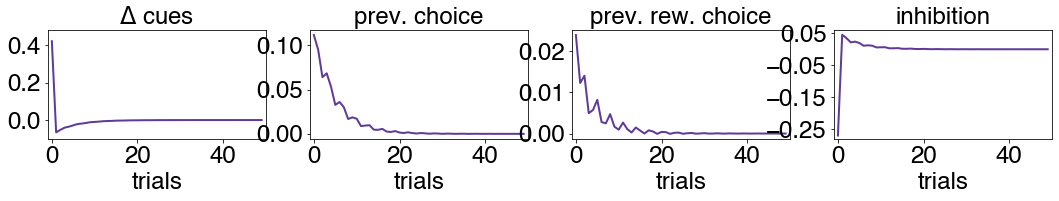

In [281]:
plt.figure(figsize=(18,2))

plt.subplot(1,4,1)
plt.plot(zs1, color=colors[0], linewidth=2)
plt.xlim([-1, 50])
plt.title('$\Delta$ cues', fontsize=24)
plt.xlabel('trials')
plt.ylim([-0.1,0.48])
plt.yticks(np.arange(-0,0.51,0.2))


plt.subplot(1,4,2)
plt.plot(zs2, color=colors[0], linewidth=2)
plt.xlim([-1, 50])
plt.title('prev. choice', fontsize=24)
plt.xlabel('trials')
plt.yticks(np.arange(0,0.11,0.05))

plt.subplot(1,4,3)
plt.plot(zs3, color=colors[0], linewidth=2)
plt.xlim([-1, 50])
plt.title('prev. rew. choice', fontsize=24)
plt.xlabel('trials')
plt.yticks(np.arange(0,0.025,0.01))

plt.subplot(1,4,4)
plt.plot(zs4, color=colors[0], linewidth=2)
plt.xlim([-1, 50])
plt.title('inhibition', fontsize=24)
plt.xlabel('trials')
plt.yticks(np.arange(-0.25,0.06,0.1))
plt.ylim([-0.28,0.06])

plt.savefig('saved_images/fig5e.pdf', transparent=True)